In [4]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."), ".."))
sys.path.append(parent_dir)
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import Counter
from data_generation.models.tech_substitution import TechnologySubstitution
from data_generation.models.tech_substitution import TechSubNumericalSolver
from data_generation.models.general_ode_solver import FitzHughNagumoModel
from data_generation.models.general_ode_solver import GeneralODENumericalSolver
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation
from data_generation.simulations.simulator import Simulator, run_and_store_simulations
from data_generation.simulations.stopping_criteria import calculate_entropy, create_stopping_by_entropy_threshold_criteria, entropy_of_uniform_distribution_over_percentage
from data_generation.visualization.create_plots import plot_2D_vector_field_over_grid

In [5]:
def plot_entropy_and_vectorfield(cell_indices, grid, num_solver, control,resolution, fig, axes, title):
    cell_data = cell_indices.reshape(-1, cell_indices.shape[-1])
    num_steps = cell_indices.shape[0] -1
    entropy_value, unique, probabilities = calculate_entropy(cell_data, base= 2)

    # Reshape probabilities to match the grid resolution
    probabilities_reshaped = probabilities.reshape(resolution)

    
    # Adjust the aspect ratio to match the grid resolution
    extent = [0, 1, 0, 1]
    im = axes.imshow(probabilities_reshaped.T, cmap='viridis', origin='lower', extent=extent, aspect='auto', alpha=0.6)
    fig.colorbar(im, ax=axes, label='Probability')
    
    plot_2D_vector_field_over_grid(grid, num_solver, control, display_vectorfield=False, display_grid = True, resolution=21, title= 'Prior Probabilities', broken_streamlines=False, ax= axes, streamplot_colour='black', vectorfield_colour='red')

    axes.set_title(title + f' - Entropy: {entropy_value:.2f}  - Num_Steps: {num_steps}')
    
    return 


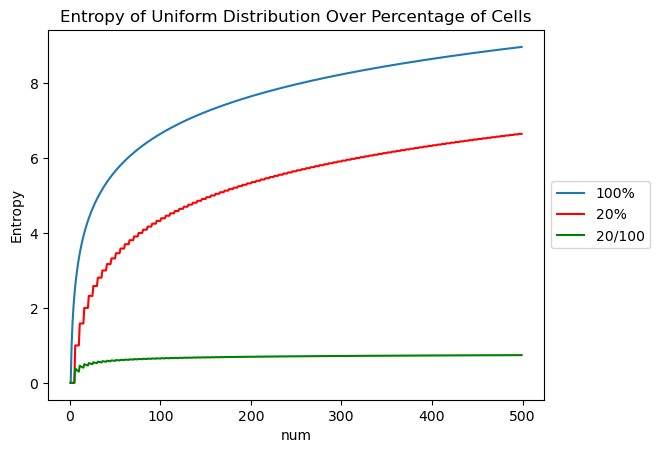

In [6]:
r = range(1,500)
values = [entropy_of_uniform_distribution_over_percentage(num, 1) for num in r]
values04 = [entropy_of_uniform_distribution_over_percentage(num, 0.2) for num in r]
v = [val04 / val if val != 0 else 0 for val, val04 in zip(values, values04)]
plt.plot(r, values)
plt.plot(r, values04, color='red')
plt.plot(r, v, color='green')
plt.xlabel('num')
plt.ylabel('Entropy')
plt.title('Entropy of Uniform Distribution Over Percentage of Cells')
plt.legend(['100%', '20%', '20/100'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Tech Substitution Test

In [7]:
bounds = [(0, np.inf), (0, np.inf)]
transformations = [fractional_transformation(3), fractional_transformation(3)]
model = TechnologySubstitution()
num_solver = TechSubNumericalSolver(model)
control = np.array(1)
resolution = [30, 30]
num_samples_per_cell = 5
num_steps = 80
max_steps = 500
delta_t = 1

In [8]:
n = np.prod(resolution)
percentage = 0.4


In [9]:
grid = Grid(bounds, resolution, transformations)
simulator = Simulator(grid, model, num_solver)
threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
threshold

np.float64(8.491853096329674)

control = np.array(1)
data1, cell_indices1, at, tr = simulator.simulate_with_stopping_criteria(control, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

control = np.array(0.5)
data05, cell_indices05, at, tr = simulator.simulate_with_stopping_criteria(control, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

plot_entropy_and_vectorfield(cell_indices05, grid, num_solver, np.array(0.5), resolution)

Caution: Maximum number of steps reached (500)
Simulation complete:
- 4500 samples × 560 timesteps = 2520000 total rows
- State dimensions: 2
- Control dimensions: 1
Stopped at entropy: 6.380229022593018 <= 6.491853096329675 (threshold)
Simulation complete:
- 4500 samples × 560 timesteps = 2520000 total rows
- State dimensions: 2
- Control dimensions: 1


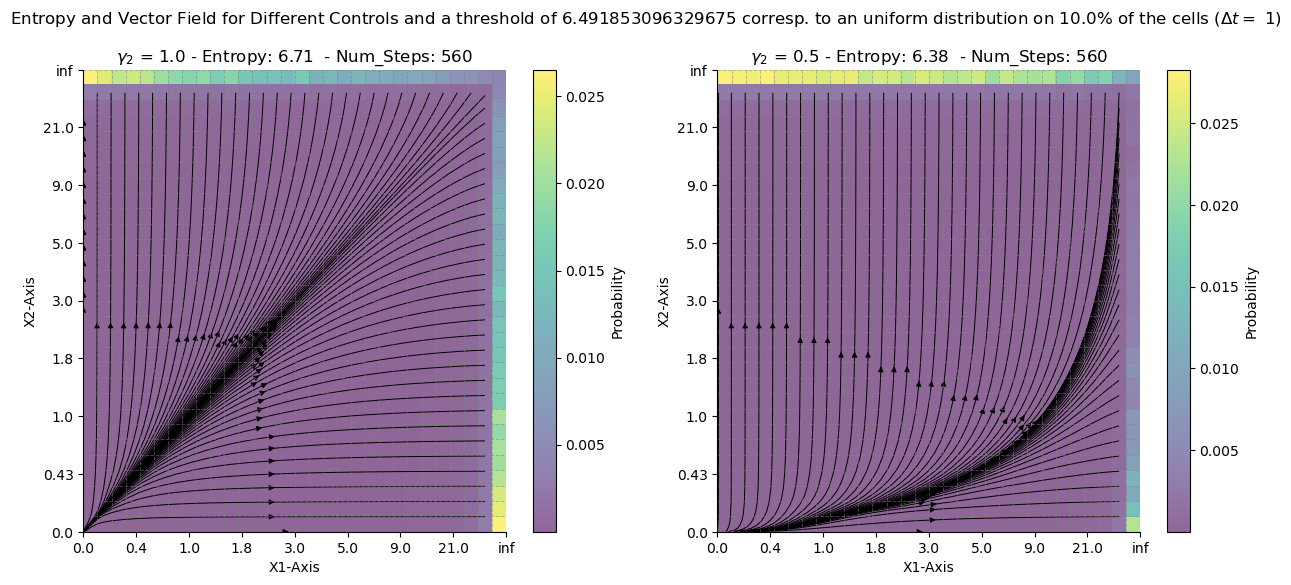

In [10]:
percentagelist = [0.1]
for percentage in percentagelist:
    threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
    stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
    control = np.array([[1], [0.5]])

    # Create a plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i in range(2):
        data, cell_indices = simulator.simulate_with_stopping_criteria(control[i], 
                                                delta_t, 
                                                stopping_criteria,
                                                num_samples_per_cell, 
                                                max_steps=max_steps,
                                                num_steps=num_steps)
        
        plot_entropy_and_vectorfield(cell_indices, grid, num_solver, control[i], resolution, fig, axes[i], r"$\gamma_{2}$ = " + str(control[i][0]))
    
    fig.suptitle(rf'Entropy and Vector Field for Different Controls and a threshold of {threshold} corresp. to an uniform distribution on {percentage*100}% of the cells ($\Delta t =$ {delta_t})')
    plt.savefig(f'entropy_vectorfield_{percentage}.png')

In [31]:
cell_indices.shape[0]


101

## FitzHugh-Nagumo Model Test

In [22]:
fbounds = [(-np.inf,np.inf),(-np.inf,np.inf)]
ftransformations = [logistic_transformation({'k': 1, 'x_0': 0}), logistic_transformation({'k': 1, 'x_0': 0})]

fmodel = FitzHughNagumoModel(control_params=['b','I'])
fnum_solver = GeneralODENumericalSolver(fmodel)
resolution = [2, 2]
num_samples_per_cell = 2
num_steps = 2
max_steps = 1
delta_t = 1

In [23]:
n = np.prod(resolution)
percentage = 0.1

In [24]:
fgrid = Grid(fbounds, resolution, ftransformations)
fsimulator = Simulator(fgrid, fmodel, fnum_solver)
threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
threshold

np.float64(0.0)

In [25]:
fcontrol = np.array([2, 0])
fdata, fcell_indices, at, tr = fsimulator.simulate_with_stopping_criteria(fcontrol, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

[[[-1.83849428 -0.22231984]
  [-1.1822501  -1.1903575 ]
  [ 0.30149128  0.63083105]
  [ 0.13989526  2.39282789]
  [-0.54840609 -1.45807811]
  [ 4.46741653  0.7872138 ]
  [-1.28766622 -0.51022808]
  [ 0.60009941  3.69930954]]

 [[-1.48856763  1.44738176]
  [-2.68464098 -1.92334055]
  [ 1.83256095  1.58658377]
  [-0.60836142 -1.08024282]
  [-0.53473767 -1.14726138]
  [ 3.68017848  0.59821127]
  [-0.9594014  -0.29672222]
  [ 0.54901987  3.24776446]]

 [[-1.40966057  2.03564909]
  [-2.57323028 -1.93048046]
  [ 2.00554039  1.77498613]
  [-1.63416584 -2.49635868]
  [-0.51031446 -0.78661921]
  [ 2.99344815  0.41796349]
  [-0.61922934 -0.07325896]
  [ 0.43250353  2.6582311 ]]]
Caution: Maximum number of steps reached (1)
X [[-1.40966057  2.03564909]
 [-2.57323028 -1.93048046]
 [ 2.00554039  1.77498613]
 [-1.63416584 -2.49635868]
 [-0.51031446 -0.78661921]
 [ 2.99344815  0.41796349]
 [-0.61922934 -0.07325896]
 [ 0.43250353  2.6582311 ]]
Simulation complete:
- 8 samples × 2 timesteps = 16 total 

In [26]:
X = np.atleast_2d(at[0][0])
fshaped_control = np.array([[fcontrol]])
traj = fnum_solver.step(X, fshaped_control, 1, 3, steady_control=True)

In [27]:
traj

array([[[-1.83849428, -0.54840609]],

       [[-1.49222669, -0.53486256]],

       [[-1.41085629, -0.51061073]],

       [[-1.39777855, -0.48692223]]])

In [28]:
tr

array([[[-1.83849428, -0.22231984],
        [-1.1822501 , -1.1903575 ],
        [ 0.30149128,  0.63083105],
        [ 0.13989526,  2.39282789],
        [-0.54840609, -1.45807811],
        [ 4.46741653,  0.7872138 ],
        [-1.28766622, -0.51022808],
        [ 0.60009941,  3.69930954]],

       [[-1.48856763,  1.44738176],
        [-2.68464098, -1.92334055],
        [ 1.83256095,  1.58658377],
        [-0.60836142, -1.08024282],
        [-0.53473767, -1.14726138],
        [ 3.68017848,  0.59821127],
        [-0.9594014 , -0.29672222],
        [ 0.54901987,  3.24776446]],

       [[-1.40966057,  2.03564909],
        [-2.57323028, -1.93048046],
        [ 2.00554039,  1.77498613],
        [-1.63416584, -2.49635868],
        [-0.51031446, -0.78661921],
        [ 2.99344815,  0.41796349],
        [-0.61922934, -0.07325896],
        [ 0.43250353,  2.6582311 ]]])

In [29]:
fdata

,run_id,trajectory_id,t0,t1,x0,x1,c0,c1,y0,y1
0,20250226_171643,0-0_0,0.0,1.0,-1.838494,-0.548406,2,0,-1.488568,1.447382
1,20250226_171643,0-0_0,1.0,2.0,-1.488568,1.447382,2,0,-1.409661,2.035649
2,20250226_171643,0-0_1,0.0,1.0,-0.222320,-1.458078,2,0,-2.684641,-1.923341
3,20250226_171643,0-0_1,1.0,2.0,-2.684641,-1.923341,2,0,-2.573230,-1.930480
4,20250226_171643,0-1_0,0.0,1.0,-1.182250,4.467417,2,0,1.832561,1.586584
5,20250226_171643,0-1_0,1.0,2.0,1.832561,1.586584,2,0,2.005540,1.774986
6,20250226_171643,0-1_1,0.0,1.0,-1.190358,0.787214,2,0,-0.608361,-1.080243
7,20250226_171643,0-1_1,1.0,2.0,-0.608361,-1.080243,2,0,-1.634166,-2.496359
8,20250226_171643,1-0_0,0.0,1.0,0.301491,-1.287666,2,0,-0.534738,-1.147261
9,20250226_171643,1-0_0,1.0,2.0,-0.534738,-1.147261,2,0,-0.510314,-0.786619


In [30]:
for i in range(7):
    print(fcell_indices[0][i], fcell_indices[1][i])

[0 0] [0 1]
[0 0] [0 0]
[0 1] [1 1]
[0 1] [0 0]
[1 0] [0 0]
[1 0] [1 1]
[1 1] [0 0]


In [31]:
fgrid.get_cell_coordinates((4,8))

[array([], dtype=float64), array([], dtype=float64)]

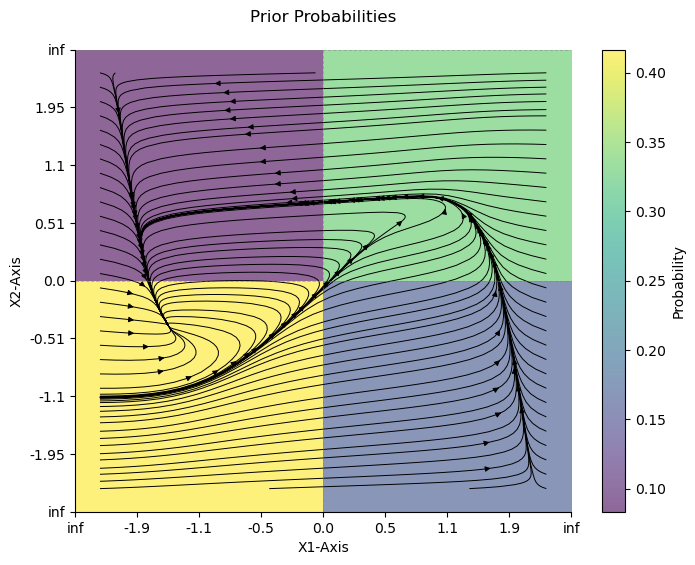

In [32]:
plot_entropy_and_vectorfield(fcell_indices, fgrid, fnum_solver, np.array([2, 0]))